# 学習
- パラメータチューニング

In [1]:
# パラメータ設定

In [2]:
TARGET_DATE = '20210101'

In [3]:
# Parameters
TARGET_DATE = 20210101


In [4]:
TARGET_DATE = str(TARGET_DATE)

In [5]:
# ライブラリ読み込み

In [6]:
import pandas as pd
import numpy as np
import argparse
import shap
import optuna
import pickle
import lightgbm as lgb
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, f1_score, precision_score
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt

In [7]:
# dataframe設定調整

In [8]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 200)

In [9]:
# データ読み込み

In [10]:
train = pd.read_pickle(f'../../data/trial/feature_{TARGET_DATE}.pkl')

In [11]:
target = 'TARGET'

In [12]:
X = train.drop(columns=target)

In [13]:
y = train[target]

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size=0.2,
                                                   random_state=0,
                                                   stratify=y)

In [15]:
X_train, X_eval, y_train, y_eval = train_test_split(X_train, y_train,
                                                    test_size=0.2,
                                                    random_state=1,
                                                    stratify=y_train)

In [16]:
categorical_features = [
# 'prefecture_code'
]

In [17]:
lgb_train = lgb.Dataset(X_train, y_train,
                       categorical_feature=categorical_features,
                        free_raw_data=False)
lgb_eval = lgb.Dataset(X_eval, y_eval, reference=lgb_train,
                       categorical_feature=categorical_features,
                       free_raw_data=False)

In [18]:
def objective(trial):

    param = {
        'objective': 'binary',
        'metric': 'auc',
        'verbosity': -1,
        'n_jobs': -1,
        'boosting_type': 'gbdt',
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
    }

    evaluation_results = {}                                     # 学習の経過を保存する箱
    model = lgb.train(
        param,                                   # 上記で設定したパラメータ
        lgb_train,                                # 使用するデータセット
        num_boost_round=1000,                     # 学習の回数
        valid_names=['train', 'valid'],           # 学習経過で表示する名称
        valid_sets=[lgb_train, lgb_eval],         # モデル検証のデータセット
        evals_result=evaluation_results,          # 学習の経過を保存
        categorical_feature=categorical_features, # カテゴリー変数を設定
        early_stopping_rounds=50,                 # アーリーストッピング
        verbose_eval=10)                          # 学習の経過の表示(10回毎)
    
    y_pred = model.predict(X_train, num_iteration=model.best_iteration)
    
    # metrics AUC
    fpr, tpr, thresholds = metrics.roc_curve(y_train, y_pred)
    score = metrics.auc(fpr, tpr)

    # metrics F1
#     score = f1_score(y_train, y_pred)

    # MLFlow
#     with mlflow.start_run() as run:
#         mlflow.log_params(param)
#         mlflow.log_metrics({'accuracy': accuracy})
#         mlflow.lightgbm.log_model(gbm, 'model', args.conda_env)
#     print('Model logged in run {}'.format(run.info.run_uuid))
    return score

In [19]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

print('Number of finished trials: {}'.format(len(study.trials)))

print('Best trial:')
trial = study.best_trial

print('  Value: {}'.format(trial.value))

print('  Params: ')
for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

[I 2021-01-18 15:02:28,689]

 A new study created in memory with name: no-name-5e4429f6-a784-4b9e-9daf-2cac32434664

Training until validation scores don't improve for 50 rounds

[10]	train's auc: 0.762807	valid's auc: 0.724769

[20]	train's auc: 0.784728	valid's auc: 0.740218

[30]	train's auc: 0.798606	valid's auc: 0.742935

[40]	train's auc: 0.810201	valid's auc: 0.74449

[50]	train's auc: 0.8217	valid's auc: 0.745425

[60]	train's auc: 0.834205	valid's auc: 0.746651

[70]	train's auc: 0.845884	valid's auc: 0.745814

[80]	train's auc: 0.856894	valid's auc: 0.744731

[90]	train's auc: 0.866277	valid's auc: 0.744724

[100]	train's auc: 0.874938	valid's auc: 0.744513

Early stopping, best iteration is:
[58]	train's auc: 0.831815	valid's auc: 0.746788

[I 2021-01-18 15:02:31,458]

 Trial 0 finished with value: 0.8318149413863671 and parameters: {'lambda_l1': 2.5817377920770687e-05, 'lambda_l2': 9.438550199246661e-05, 'num_leaves': 108, 'feature_fraction': 0.42591777290422755, 'bagging_fraction': 0.8468900355219757, 'bagging_freq': 6, 'min_child_samples': 27}. Best is trial 0 with value: 0.8318149413863671.

Training until validation scores don't improve for 50 rounds

[10]	train's auc: 0.791411	valid's auc: 0.733008

[20]	train's auc: 0.81357	valid's auc: 0.741521

[30]	train's auc: 0.831904	valid's auc: 0.742572

[40]	train's auc: 0.848536	valid's auc: 0.743678

[50]	train's auc: 0.865086	valid's auc: 0.744202

[60]	train's auc: 0.880963	valid's auc: 0.74443

[70]	train's auc: 0.894612	valid's auc: 0.744625

[80]	train's auc: 0.90729	valid's auc: 0.743555

[90]	train's auc: 0.918712	valid's auc: 0.743323

[100]	train's auc: 0.927687	valid's auc: 0.742292

[110]	train's auc: 0.936058	valid's auc: 0.74181

Early stopping, best iteration is:
[65]	train's auc: 0.887651	valid's auc: 0.744936

[I 2021-01-18 15:02:35,203]

 Trial 1 finished with value: 0.8876512135023438 and parameters: {'lambda_l1': 0.6735564797726852, 'lambda_l2': 0.0038297684274387097, 'num_leaves': 221, 'feature_fraction': 0.4758470496803634, 'bagging_fraction': 0.9827503036652119, 'bagging_freq': 2, 'min_child_samples': 84}. Best is trial 1 with value: 0.8876512135023438.

Training until validation scores don't improve for 50 rounds

[10]	train's auc: 0.781643	valid's auc: 0.722069

[20]	train's auc: 0.806633	valid's auc: 0.738539

[30]	train's auc: 0.822892	valid's auc: 0.741187

[40]	train's auc: 0.83799	valid's auc: 0.742827

[50]	train's auc: 0.853396	valid's auc: 0.743845

[60]	train's auc: 0.868428	valid's auc: 0.74357

[70]	train's auc: 0.881806	valid's auc: 0.743197

[80]	train's auc: 0.893628	valid's auc: 0.742187

[90]	train's auc: 0.904377	valid's auc: 0.740489

[100]	train's auc: 0.91487	valid's auc: 0.739445

Early stopping, best iteration is:
[56]	train's auc: 0.862473	valid's auc: 0.744496

[I 2021-01-18 15:02:41,605]

 Trial 2 finished with value: 0.8624733792091723 and parameters: {'lambda_l1': 9.843516656550114e-05, 'lambda_l2': 0.016788862060896737, 'num_leaves': 203, 'feature_fraction': 0.41282974216311064, 'bagging_fraction': 0.7342234918127726, 'bagging_freq': 5, 'min_child_samples': 76}. Best is trial 1 with value: 0.8876512135023438.

Training until validation scores don't improve for 50 rounds

[10]	train's auc: 0.775048	valid's auc: 0.730477

[20]	train's auc: 0.804467	valid's auc: 0.733498

[30]	train's auc: 0.829808	valid's auc: 0.736937

[40]	train's auc: 0.850805	valid's auc: 0.736245

[50]	train's auc: 0.869111	valid's auc: 0.73616

[60]	train's auc: 0.884815	valid's auc: 0.73569

[70]	train's auc: 0.897834	valid's auc: 0.735218

[80]	train's auc: 0.909817	valid's auc: 0.733406

Early stopping, best iteration is:
[34]	train's auc: 0.838445	valid's auc: 0.737376

[I 2021-01-18 15:02:44,006]

 Trial 3 finished with value: 0.8384454553758723 and parameters: {'lambda_l1': 2.663106702307728e-06, 'lambda_l2': 0.0004199077618805182, 'num_leaves': 194, 'feature_fraction': 0.8650336869338363, 'bagging_fraction': 0.5907373262967588, 'bagging_freq': 4, 'min_child_samples': 33}. Best is trial 1 with value: 0.8876512135023438.

Training until validation scores don't improve for 50 rounds

[10]	train's auc: 0.755696	valid's auc: 0.731047

[20]	train's auc: 0.770797	valid's auc: 0.735643

[30]	train's auc: 0.784556	valid's auc: 0.739456

[40]	train's auc: 0.797132	valid's auc: 0.740152

[50]	train's auc: 0.807967	valid's auc: 0.741185

[60]	train's auc: 0.81844	valid's auc: 0.741714

[70]	train's auc: 0.827538	valid's auc: 0.739585

[80]	train's auc: 0.83562	valid's auc: 0.738693

[90]	train's auc: 0.844143	valid's auc: 0.738865

[100]	train's auc: 0.850859	valid's auc: 0.739248

Early stopping, best iteration is:
[54]	train's auc: 0.812529	valid's auc: 0.742126

[I 2021-01-18 15:02:46,604]

 Trial 4 finished with value: 0.812528570301624 and parameters: {'lambda_l1': 1.5843662058319236e-05, 'lambda_l2': 6.206040713570412e-06, 'num_leaves': 84, 'feature_fraction': 0.8970258577921453, 'bagging_fraction': 0.4205799392436117, 'bagging_freq': 1, 'min_child_samples': 66}. Best is trial 1 with value: 0.8876512135023438.

Training until validation scores don't improve for 50 rounds

[10]	train's auc: 0.772981	valid's auc: 0.729501

[20]	train's auc: 0.801657	valid's auc: 0.734612

[30]	train's auc: 0.824409	valid's auc: 0.737195

[40]	train's auc: 0.845856	valid's auc: 0.737839

[50]	train's auc: 0.863722	valid's auc: 0.738614

[60]	train's auc: 0.878684	valid's auc: 0.737646

[70]	train's auc: 0.893108	valid's auc: 0.735707

[80]	train's auc: 0.904125	valid's auc: 0.734725

[90]	train's auc: 0.915909	valid's auc: 0.732769

Early stopping, best iteration is:
[46]	train's auc: 0.85672	valid's auc: 0.738979

[I 2021-01-18 15:02:50,329]

 Trial 5 finished with value: 0.8567200706394897 and parameters: {'lambda_l1': 1.1222454172577648e-05, 'lambda_l2': 0.000726574467972726, 'num_leaves': 188, 'feature_fraction': 0.92062042669745, 'bagging_fraction': 0.6795767361144331, 'bagging_freq': 4, 'min_child_samples': 66}. Best is trial 1 with value: 0.8876512135023438.

Training until validation scores don't improve for 50 rounds

[10]	train's auc: 0.765207	valid's auc: 0.730934

[20]	train's auc: 0.786417	valid's auc: 0.736527

[30]	train's auc: 0.805753	valid's auc: 0.739187

[40]	train's auc: 0.82281	valid's auc: 0.737951

[50]	train's auc: 0.837823	valid's auc: 0.738037

[60]	train's auc: 0.851343	valid's auc: 0.737088

[70]	train's auc: 0.863835	valid's auc: 0.735953

[80]	train's auc: 0.874168	valid's auc: 0.735355

Early stopping, best iteration is:
[34]	train's auc: 0.81265	valid's auc: 0.739469

[I 2021-01-18 15:02:52,394]

 Trial 6 finished with value: 0.8126495142239367 and parameters: {'lambda_l1': 4.911342065023171e-05, 'lambda_l2': 1.1459932246754233e-08, 'num_leaves': 138, 'feature_fraction': 0.9190633043513995, 'bagging_fraction': 0.48633581205187004, 'bagging_freq': 3, 'min_child_samples': 48}. Best is trial 1 with value: 0.8876512135023438.

Training until validation scores don't improve for 50 rounds

[10]	train's auc: 0.778041	valid's auc: 0.7373

[20]	train's auc: 0.79652	valid's auc: 0.741434

[30]	train's auc: 0.811941	valid's auc: 0.741745

[40]	train's auc: 0.826322	valid's auc: 0.742326

[50]	train's auc: 0.83954	valid's auc: 0.743348

[60]	train's auc: 0.854414	valid's auc: 0.743396

[70]	train's auc: 0.865457	valid's auc: 0.743852

[80]	train's auc: 0.876396	valid's auc: 0.743367

[90]	train's auc: 0.886625	valid's auc: 0.742566

[100]	train's auc: 0.895564	valid's auc: 0.741932

[110]	train's auc: 0.904491	valid's auc: 0.741939

[120]	train's auc: 0.91176	valid's auc: 0.740768

Early stopping, best iteration is:
[70]	train's auc: 0.865457	valid's auc: 0.743852

[I 2021-01-18 15:02:55,587]

 Trial 7 finished with value: 0.8654565376337782 and parameters: {'lambda_l1': 0.012792407197730152, 'lambda_l2': 1.0398076688708622e-08, 'num_leaves': 147, 'feature_fraction': 0.5826353803537193, 'bagging_fraction': 0.8642817209464587, 'bagging_freq': 6, 'min_child_samples': 71}. Best is trial 1 with value: 0.8876512135023438.

Training until validation scores don't improve for 50 rounds

[10]	train's auc: 0.748712	valid's auc: 0.726055

[20]	train's auc: 0.763671	valid's auc: 0.740947

[30]	train's auc: 0.770529	valid's auc: 0.743581

[40]	train's auc: 0.776861	valid's auc: 0.745499

[50]	train's auc: 0.783703	valid's auc: 0.746772

[60]	train's auc: 0.790179	valid's auc: 0.747737

[70]	train's auc: 0.795986	valid's auc: 0.748135

[80]	train's auc: 0.80125	valid's auc: 0.748615

[90]	train's auc: 0.806831	valid's auc: 0.748099

[100]	train's auc: 0.81233	valid's auc: 0.748492

[110]	train's auc: 0.816958	valid's auc: 0.748855

[120]	train's auc: 0.821926	valid's auc: 0.748787

[130]	train's auc: 0.826633	valid's auc: 0.748137

[140]	train's auc: 0.831304	valid's auc: 0.748088

[150]	train's auc: 0.835467	valid's auc: 0.747847

[160]	train's auc: 0.839643	valid's auc: 0.747712

Early stopping, best iteration is:
[118]	train's auc: 0.820941	valid's auc: 0.749051

[I 2021-01-18 15:02:59,391]

 Trial 8 finished with value: 0.8209411040425287 and parameters: {'lambda_l1': 0.32457237997795596, 'lambda_l2': 0.352397147240088, 'num_leaves': 50, 'feature_fraction': 0.43690650066571907, 'bagging_fraction': 0.7631495889601814, 'bagging_freq': 5, 'min_child_samples': 28}. Best is trial 1 with value: 0.8876512135023438.

Training until validation scores don't improve for 50 rounds

[10]	train's auc: 0.778182	valid's auc: 0.734736

[20]	train's auc: 0.800512	valid's auc: 0.738237

[30]	train's auc: 0.819807	valid's auc: 0.740157

[40]	train's auc: 0.838688	valid's auc: 0.740967

[50]	train's auc: 0.854307	valid's auc: 0.741698

[60]	train's auc: 0.869923	valid's auc: 0.741167

[70]	train's auc: 0.883378	valid's auc: 0.741296

[80]	train's auc: 0.895491	valid's auc: 0.739711

[90]	train's auc: 0.906248	valid's auc: 0.739095

[100]	train's auc: 0.91508	valid's auc: 0.738667

Early stopping, best iteration is:
[55]	train's auc: 0.862066	valid's auc: 0.742103

[I 2021-01-18 15:03:02,310]

 Trial 9 finished with value: 0.8620661564391121 and parameters: {'lambda_l1': 6.582604874826759e-07, 'lambda_l2': 2.0562729619836776e-07, 'num_leaves': 162, 'feature_fraction': 0.6457237034216085, 'bagging_fraction': 0.6985146060063692, 'bagging_freq': 3, 'min_child_samples': 35}. Best is trial 1 with value: 0.8876512135023438.

Number of finished trials: 10

Best trial:

  Value: 0.8876512135023438

  Params: 

    lambda_l1: 0.6735564797726852

    lambda_l2: 0.0038297684274387097

    num_leaves: 221

    feature_fraction: 0.4758470496803634

    bagging_fraction: 0.9827503036652119

    bagging_freq: 2

    min_child_samples: 84

In [20]:
# 二値分類
params = {
            'boosting_type': 'gbdt',        # 勾配ブースティング
            'objective': 'binary',      # 目的関数：多値分類、マルチクラス分類
            'metric': 'auc',      # 分類モデルの性能を測る指標
         }

In [21]:
params = dict(params, **study.best_params)

In [22]:
evaluation_results = {}                                     # 学習の経過を保存する箱
model = lgb.train(params,                                   # 上記で設定したパラメータ
                  lgb_train,                                # 使用するデータセット
                  num_boost_round=1000,                     # 学習の回数
                  valid_names=['train', 'valid'],           # 学習経過で表示する名称
                  valid_sets=[lgb_train, lgb_eval],         # モデル検証のデータセット
                  evals_result=evaluation_results,          # 学習の経過を保存
                  categorical_feature=categorical_features, # カテゴリー変数を設定
                  early_stopping_rounds=50,                 # アーリーストッピング
                  verbose_eval=10)                          # 学習の経過の表示(10回毎)

# 最もスコアが良いときのラウンドを保存
optimum_boost_rounds = model.best_iteration

[LightGBM] [Warning] 

Find whitespaces in feature_names, replace with underlines

[LightGBM] [Info] 

Number of positive: 15390, number of negative: 175016

[LightGBM] [Warning] 

Auto-choosing row-wise multi-threading, the overhead of testing was 0.005319 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.

[LightGBM] [Info] 

Total Bins 3201

[LightGBM] [Info] 

Number of data points in the train set: 190406, number of used features: 26

[LightGBM] [Info] 

[binary:BoostFromScore]: pavg=0.080827 -> initscore=-2.431159

[LightGBM] [Info] 

Start training from score -2.431159

Training until validation scores don't improve for 50 rounds

[10]	train's auc: 0.791411	valid's auc: 0.733008

[20]	train's auc: 0.81357	valid's auc: 0.741521

[30]	train's auc: 0.831904	valid's auc: 0.742572

[40]	train's auc: 0.848536	valid's auc: 0.743678

[50]	train's auc: 0.865086	valid's auc: 0.744202

[60]	train's auc: 0.880963	valid's auc: 0.74443

[70]	train's auc: 0.894612	valid's auc: 0.744625

[80]	train's auc: 0.90729	valid's auc: 0.743555

[90]	train's auc: 0.918712	valid's auc: 0.743323

[100]	train's auc: 0.927687	valid's auc: 0.742292

[110]	train's auc: 0.936058	valid's auc: 0.74181

Early stopping, best iteration is:
[65]	train's auc: 0.887651	valid's auc: 0.744936

0.8876512135023438

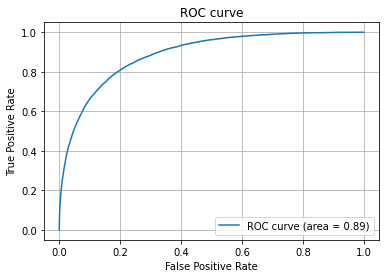

In [23]:
# # 訓練データで予測
y_pred = model.predict(X_train, num_iteration=model.best_iteration)
y_pred_max = np.round(y_pred)
fpr, tpr, thresholds = metrics.roc_curve(y_train, y_pred)
auc = metrics.auc(fpr, tpr)
print(auc)
plt.plot(fpr, tpr, label='ROC curve (area = %.2f)'%auc)
plt.legend()
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

0.7544324204466548

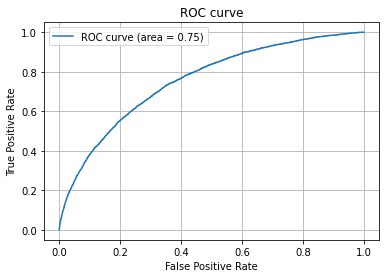

In [24]:
# # テストデータで予測
y_pred = model.predict(X_test, num_iteration=model.best_iteration)
y_pred_max = np.round(y_pred)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
auc = metrics.auc(fpr, tpr)
print(auc)
plt.plot(fpr, tpr, label='ROC curve (area = %.2f)'%auc)
plt.legend()
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

In [25]:
pickle.dump(model, open(f'../../data/trial/model_{TARGET_DATE}.pkl', 'wb'))